### Import main torch module and test if GPU avaliable

In [1]:
import torch


use_cuda = torch.cuda.is_available()
print("Using cuda? ", use_cuda)


Using cuda?  True


### Loading and taking a look to input images

data/train/melanoma/ISIC_0028582.jpeg


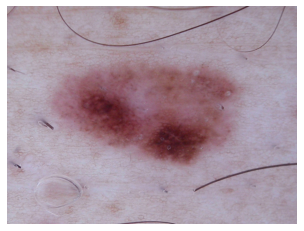

data/train/nevus/ISIC_0004363.jpeg


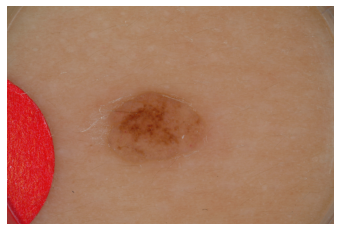

data/train/seborrheic_keratosis/ISIC_0014811.jpg


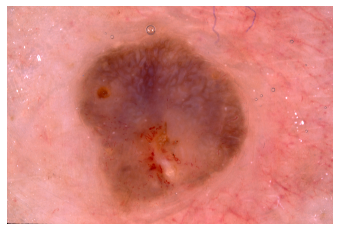

In [2]:
import os
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

### Taking a look of how a smaple image looks like

def imshow2(image):
    img = cv2.imread(image)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.axis('off')
    plt.show()

img_train_pth = "data/train/melanoma"
img_train_pth1 = "data/train/nevus"
img_train_pth2 = "data/train/seborrheic_keratosis"
sample_img = os.path.join(img_train_pth, os.listdir(img_train_pth)[0])
sample_img1 = os.path.join(img_train_pth1, os.listdir(img_train_pth1)[0])
sample_img2 = os.path.join(img_train_pth2, os.listdir(img_train_pth2)[0])

print(sample_img)
imshow2(sample_img)
print(sample_img1)
imshow2(sample_img1)
print(sample_img2)
imshow2(sample_img2)

### Image Transformation, dataset process and augmentation

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms
from collections import Counter

img_size = 224 

pixel_normalization = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    pixel_normalization
])

valid_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    pixel_normalization
])

test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    pixel_normalization
])

train_data = datasets.ImageFolder("data/train/", transform=train_transform)
valid_data = datasets.ImageFolder("data/valid/", transform=valid_transform)
test_data = datasets.ImageFolder("data/test/", transform=test_transform)

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight   

weights = make_weights_for_balanced_classes(train_data.imgs, len(train_data.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
#train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = True)                              
                                                             
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



### How processed data looks like

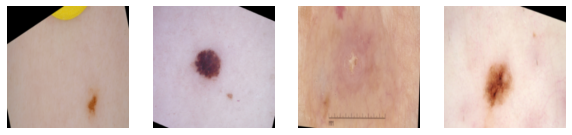

In [4]:
import numpy as np

def imshow_fromTensor(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')
    
    
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    imshow_fromTensor(images[ii], ax=ax)


### VGG16 model pretrained and fine-tuning 

In [ ]:
from torchvision import models
from torch import nn
from collections import OrderedDict 

model = models.vgg16(pretrained=True)
#print(vgg16)

## frezing feature layers
for param in model.features.parameters():
    param.requires_grad = False
    
    
in_classifier_features = model.classifier[0].in_features
n_classes = len(train_data.classes)

## Lets build the classifier part

classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_classifier_features, 1024)), 
    ("relu", nn.ReLU()),
    ("drop", nn.Dropout(0.5)),
    ("fc2", nn.Linear(1024, 512)), 
    ("relu2", nn.ReLU()),
    ("fc3", nn.Linear(512, n_out_classes)), 
]))

model.classifier = classifier ## Get ride of the classifier part and and implement in our own
print(model)

if use_cuda:
    model.cuda()

### Second Attemp, let's try with ResNet

In [5]:
from torchvision import models
from torch import nn
from collections import OrderedDict 

model = models.resnet152(pretrained=True)

in_classifier_features = model.fc.in_features
n_classes = len(train_data.classes)
#print(resnet)

## frezing feature layers
for param in model.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default

#model.fc = nn.Linear(in_features, n_classes)
classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_classifier_features, 1024)), 
    ("relu", nn.ReLU()),
    ("drop", nn.Dropout(0.3)),
    ("fc2", nn.Linear(1024, 512)), 
    ("relu2", nn.ReLU()),
    ("fc3", nn.Linear(512, n_classes)), 
]))
model.fc = classifier
print(model)

if use_cuda:
    model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss and optimizer

In [6]:
from torch import optim

criterion_entropy = nn.CrossEntropyLoss()

#optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001) # for vgg16
optimizer_adam = optim.Adam(model.fc.parameters(), lr=0.001) # for resnet


### Training process 

In [7]:
def train(n_epochs, model, training_data_loader, validation_data_loader, criterion=criterion_entropy, optimizer=optimizer_adam, use_cuda=use_cuda, save_path="model_derma.pt", valid_loss_min=np.Inf):
    
    for epoch in range(n_epochs):
        
        running_loss = 0
        valid_loss = 0
        valid_accuracy = 0        
        
        model.train()
        
        for image_batch, target_batch in training_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            optimizer.zero_grad()
            
            out = model.forward(image_batch)
            
            loss = criterion(out, target_batch)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() 
            
        train_loss = running_loss/len(train_loader)

        model.eval()
        for image_batch, target_batch in validation_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            out = model.forward(image_batch)
            
            ## Compute validation loss
            loss = criterion(out, target_batch)
            
            valid_loss += loss.item() 
            
            ## Compute validation accuracy
            top_p, top_class = out.topk(1, dim=1)
            equals = top_class == target_batch.view(*top_class.shape)                    
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        valid_loss = valid_loss/len(validation_data_loader)
        valid_accuracy = valid_accuracy/len(validation_data_loader)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValid Accuracy: {:.3f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_accuracy
        ))
        
        if valid_loss < valid_loss_min:            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model
            

### VGG training

In [ ]:
import numpy as np
model = train(50, model, train_loader, valid_loader, save_path="model_derma2.pt", valid_loss_min=np.Inf)

Epoch: 1 	Training Loss: 0.865418 	Validation Loss: 0.938073 	Valid Accuracy: 0.571
Validation loss decreased (inf --> 0.938073).  Saving model ...
Epoch: 2 	Training Loss: 0.748592 	Validation Loss: 0.773063 	Valid Accuracy: 0.655
Validation loss decreased (0.938073 --> 0.773063).  Saving model ...
Epoch: 3 	Training Loss: 0.707526 	Validation Loss: 0.963921 	Valid Accuracy: 0.518
Epoch: 4 	Training Loss: 0.694334 	Validation Loss: 0.771153 	Valid Accuracy: 0.631
Validation loss decreased (0.773063 --> 0.771153).  Saving model ...
Epoch: 5 	Training Loss: 0.684547 	Validation Loss: 0.690601 	Valid Accuracy: 0.667
Validation loss decreased (0.771153 --> 0.690601).  Saving model ...
Epoch: 6 	Training Loss: 0.664794 	Validation Loss: 0.779931 	Valid Accuracy: 0.595
Epoch: 7 	Training Loss: 0.646955 	Validation Loss: 0.720684 	Valid Accuracy: 0.673
Epoch: 8 	Training Loss: 0.636013 	Validation Loss: 0.816291 	Valid Accuracy: 0.667
Epoch: 9 	Training Loss: 0.620558 	Validation Loss: 0.752

### Resnet Training

In [9]:
import numpy as np
model = train(20, model, train_loader, valid_loader, save_path="model_derma_resnet2.pt")

Epoch: 0 	Training Loss: 0.683481 	Validation Loss: 0.912978 	Valid Accuracy: 0.550
Validation loss decreased (inf --> 0.912978).  Saving model ...
Epoch: 1 	Training Loss: 0.661719 	Validation Loss: 0.770287 	Valid Accuracy: 0.670
Validation loss decreased (0.912978 --> 0.770287).  Saving model ...
Epoch: 2 	Training Loss: 0.655428 	Validation Loss: 0.774138 	Valid Accuracy: 0.658
Epoch: 3 	Training Loss: 0.620605 	Validation Loss: 0.855735 	Valid Accuracy: 0.588
Epoch: 4 	Training Loss: 0.607611 	Validation Loss: 1.054323 	Valid Accuracy: 0.582
Epoch: 5 	Training Loss: 0.578446 	Validation Loss: 0.754230 	Valid Accuracy: 0.665
Validation loss decreased (0.770287 --> 0.754230).  Saving model ...
Epoch: 6 	Training Loss: 0.596865 	Validation Loss: 0.880104 	Valid Accuracy: 0.618
Epoch: 7 	Training Loss: 0.558590 	Validation Loss: 0.817796 	Valid Accuracy: 0.636
Epoch: 8 	Training Loss: 0.563286 	Validation Loss: 0.756574 	Valid Accuracy: 0.671
Epoch: 9 	Training Loss: 0.576745 	Validat

Targets used for training:  dict_items([(0, 1530), (1, 1561), (2, 1589)])
Epoch: 0 	Training Loss: 0.641440 	Validation Loss: 0.976987 	Valid Accuracy: 0.607
Validation loss decreased (inf --> 0.976987).  Saving model ...
Targets used for training:  dict_items([(0, 1588), (2, 1505), (1, 1587)])
Epoch: 1 	Training Loss: 0.641989 	Validation Loss: 0.811496 	Valid Accuracy: 0.619
Validation loss decreased (0.976987 --> 0.811496).  Saving model ...
Targets used for training:  dict_items([(1, 1554), (2, 1542), (0, 1584)])
Epoch: 2 	Training Loss: 0.657855 	Validation Loss: 0.746863 	Valid Accuracy: 0.679
Validation loss decreased (0.811496 --> 0.746863).  Saving model ...
Targets used for training:  dict_items([(1, 1579), (2, 1508), (0, 1593)])
Epoch: 3 	Training Loss: 0.614053 	Validation Loss: 0.811514 	Valid Accuracy: 0.649
Targets used for training:  dict_items([(2, 1564), (1, 1554), (0, 1562)])
Epoch: 4 	Training Loss: 0.615348 	Validation Loss: 0.785215 	Valid Accuracy: 0.649
Targets used for training:  dict_items([(0, 1562), (1, 1556), (2, 1562)])
Epoch: 5 	Training Loss: 0.627260 	Validation Loss: 0.845122 	Valid Accuracy: 0.637
Targets used for training:  dict_items([(2, 1588), (1, 1557), (0, 1535)])
Epoch: 6 	Training Loss: 0.610363 	Validation Loss: 0.794297 	Valid Accuracy: 0.655
Targets used for training:  dict_items([(2, 1549), (0, 1610), (1, 1521)])
Epoch: 7 	Training Loss: 0.610954 	Validation Loss: 0.800404 	Valid Accuracy: 0.619
Targets used for training:  dict_items([(0, 1553), (2, 1600), (1, 1527)])
Epoch: 8 	Training Loss: 0.601186 	Validation Loss: 0.697169 	Valid Accuracy: 0.643
Validation loss decreased (0.746863 --> 0.697169).  Saving model ...
Targets used for training:  dict_items([(0, 1595), (1, 1588), (2, 1497)])
Epoch: 9 	Training Loss: 0.622668 	Validation Loss: 0.795134 	Valid Accuracy: 0.589
Targets used for training:  dict_items([(0, 1541), (2, 1585), (1, 1554)])
Epoch: 10 	Training Loss: 0.600772 	Validation Loss: 0.971693 	Valid Accuracy: 0.565
Targets used for training:  dict_items([(0, 1590), (2, 1580), (1, 1510)])
Epoch: 11 	Training Loss: 0.592357 	Validation Loss: 0.870613 	Valid Accuracy: 0.583
Targets used for training:  dict_items([(2, 1582), (0, 1571), (1, 1527)])
Epoch: 12 	Training Loss: 0.610324 	Validation Loss: 0.919855 	Valid Accuracy: 0.589
Targets used for training:  dict_items([(1, 1530), (0, 1589), (2, 1561)])
Epoch: 13 	Training Loss: 0.620863 	Validation Loss: 0.756896 	Valid Accuracy: 0.649
Targets used for training:  dict_items([(2, 1530), (1, 1518), (0, 1632)])
Epoch: 14 	Training Loss: 0.617199 	Validation Loss: 0.679359 	Valid Accuracy: 0.667
Validation loss decreased (0.697169 --> 0.679359).  Saving model ...
Targets used for training:  dict_items([(0, 1562), (1, 1564), (2, 1554)])
Epoch: 15 	Training Loss: 0.603758 	Validation Loss: 0.908620 	Valid Accuracy: 0.583
Targets used for training:  dict_items([(0, 1554), (1, 1597), (2, 1529)])
Epoch: 16 	Training Loss: 0.603212 	Validation Loss: 0.739530 	Valid Accuracy: 0.643
Targets used for training:  dict_items([(0, 1601), (2, 1537), (1, 1542)])
Epoch: 17 	Training Loss: 0.595949 	Validation Loss: 0.661599 	Valid Accuracy: 0.714
Validation loss decreased (0.679359 --> 0.661599).  Saving model ...
Targets used for training:  dict_items([(2, 1575), (0, 1594), (1, 1511)])
Epoch: 18 	Training Loss: 0.584246 	Validation Loss: 0.812455 	Valid Accuracy: 0.625
Targets used for training:  dict_items([(0, 1509), (1, 1630), (2, 1541)])
Epoch: 19 	Training Loss: 0.585092 	Validation Loss: 0.806264 	Valid Accuracy: 0.601


model = train(20, model, train_loader, valid_loader, save_path="model_derma_resnet.pt", valid_loss_min=0.661599)

### Test Process

In [15]:
import numpy as np

def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        data.shape
        
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### Vgg16 Test

In [ ]:
model.load_state_dict(torch.load('model_derma.pt'))
test(test_loader, model, criterion_entropy, use_cuda)

### ResNet Test

In [17]:
model.load_state_dict(torch.load('model_derma_resnet.pt'))
test(test_loader, model, criterion_entropy, use_cuda)

Test Loss: 1.057704


Test Accuracy: 49% (299/600)


In [21]:
import pandas as pd
df_original = pd.read_csv('data/HAM10000_metadata.csv')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes #Also Convert each lesion to  a numerical code.

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


In [22]:
#Creating a new dataframe df_undup that contains only the non-duplicate elements.
df_undup = df_original.groupby('lesion_id').count()
#Filters out so that we have only one image associated with each lesion_id
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1


In [23]:
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'
df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,duplicated


In [24]:
df_original['cell_type_idx'].value_counts()
df_original.shape

(10015, 10)

In [25]:
data_aug_rate = [15,10,5,50,0,40,5] #Setting augmentation rates according to ratio of examples in dataset.
for i in range(7):
    if data_aug_rate[i]:
        df_original=df_original.append([df_original.loc[df_original['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_original['cell_type_idx'].value_counts()

4    6705
3    5750
5    5680
6    5565
2    5495
1    5140
0    4905
Name: cell_type_idx, dtype: int64

In [26]:
df_original.shape

(39240, 10)